In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm
import re
import spacy
nlp = spacy.load("en_core_web_sm")
import tqdm

In [38]:
df = pd.read_csv('dataset/dfmw_combined.csv') #Read pre-prep data

In [39]:
df.head(2) #got unnamed column / Class 1 : Mac subreddit

,Unnamed: 0,Class,message
0,0,1,My Mac crashes when connecting USB Razer mouse...
1,3,1,Some questions regarding macOS Sierra public b...


In [40]:
df.tail(2) # Concat Class 0 : Windows subreddit

,Unnamed: 0,Class,message
21245,28221,0,Google ecosystem on Windows For those of you w...
21246,28223,0,Why are there no Hindi or Thai or Vietnamese o...


In [41]:
df.shape #Total 21,247 rows 3 columns

(21247, 3)

In [42]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
#drop unnamed column

In [43]:
df.head(2) #check result

,Class,message
0,1,My Mac crashes when connecting USB Razer mouse...
1,1,Some questions regarding macOS Sierra public b...


In [44]:
df['Class'].value_counts(normalize=True) #Check Baseline Accuracy 51%

Class
1    0.51146
0    0.48854
Name: proportion, dtype: float64

In [45]:
X = df['message'] #Define X as text
y = df['Class'] #Define Y as class

In [46]:
#Split train and validation data to 67% and 33%
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [47]:
#Add subreddit words into stopword to filter out when we do CountVectorizer
no_stopword = ['windows','mac','os']
for i in stopwords.words('english'):
    no_stopword.append(i)

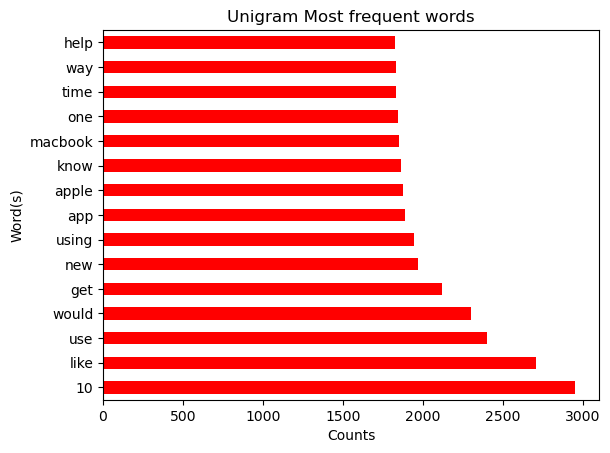

In [85]:
cvec0 = CountVectorizer(stop_words=no_stopword, ngram_range=(1,1), max_features=5000)
X_train_vec =cvec0.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_vec[:8000].todense(),
                          columns=cvec0.get_feature_names_out())
X_train_df.head()
#plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(15).plot(kind='barh',color='r')
plt.title('Unigram Most frequent words')
plt.ylabel('Word(s)')
plt.xlabel('Counts');

Text(0.5, 0, 'Counts')

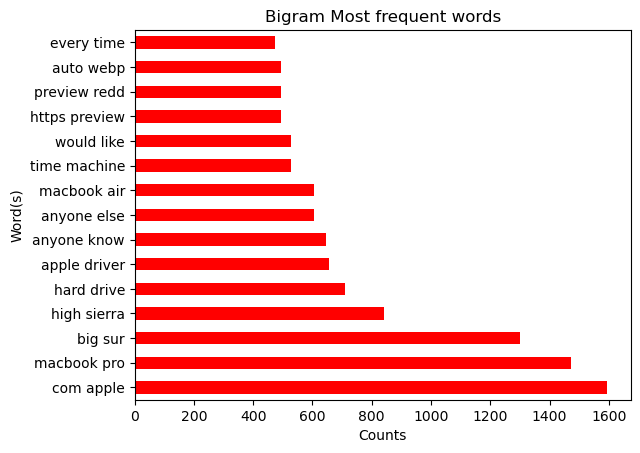

In [84]:
#Memory Error (Maybe RAM is not enough to display)
cvec2 = CountVectorizer(stop_words=no_stopword, ngram_range=(2,2), max_features=5000)
X_train_vec2 =cvec2.fit_transform(X_train)
X_train_df2 = pd.DataFrame(X_train_vec2.todense(),
                          columns=cvec2.get_feature_names_out())
X_train_df2.head()
#plot top occuring words
X_train_df2.sum().sort_values(ascending=False).head(15).plot(kind='barh',color='r');
plt.title('Bigram Most frequent words')
plt.ylabel('Word(s)')
plt.xlabel('Counts')

# Model1: Logistic Regression using GridSearch

In [12]:
#Create pipeline to do tokenize and logistic regression at the same time
pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=no_stopword)),
    ('lr', LogisticRegression(max_iter=500))])

In [13]:
#determine hyperparameters
pipe_params = {
               'cvec__max_features':[2000,3000,4000,5000], #word counts
               'cvec__min_df':[2,3], #use only words that appear at least 2 or 3 entities
               'cvec__max_df':[0.9,0.95], # exclude 5 or 10% of frequently occured words
               'cvec__ngram_range' : [(1,1),(1,2),(1,3)] # [ one-gram only, one-gram @ 2-gram]
              }

In [14]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5,
                 verbose=1) # 5-fold cross-validation.

In [15]:
# Fit GridSearch to training data.
gs.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['windows',
                                                                    'mac', 'os',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', ...])),
                                       ('lr',
                                        LogisticRegression(max_iter=500))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [16]:
gs.best_score_ #Best recall score

0.9260273972602739

In [17]:
gs.best_params_ #Best params in case we use to determine specific cvec parameters 
#for model that took too long computing both cvec and modeling

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [18]:
gs.score(X_train,y_train) #accuracy score on train set

0.9920618194590798

In [19]:
gs.score(X_test,y_test) #accuracy score on validation set

0.9251283513976041

In [20]:
preds = gs.predict(X_test) #predict class
preds # display class

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [21]:
confusion_matrix(y_test,preds) #display confusion matrix

array([[3204,  222],
       [ 303, 3283]], dtype=int64)

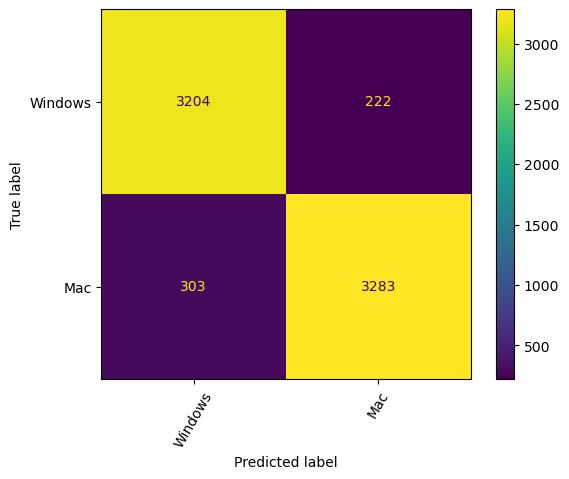

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,preds), display_labels = ['Windows', 'Mac'])
disp.plot(xticks_rotation=60)
#display confusion matrix graph

In [23]:
# tp: Mac
# tn: Windows
# fn: predicted Windows and actually Mac
# fp: predicted Mac and actualy Windows
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()

In [24]:
# Calculate the specificity (negative class)
tn/ (tn+fp)

0.9352014010507881

In [25]:
# Sensitivity (positive class)
tp/(tp+fn)

0.9155047406581149

In [26]:
# F1 Score -> harmonic mean of precision and recall.
f1_score(y_test, preds)

0.9259624876604147

In [27]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 3204
False Positives: 222
False Negatives: 303
True Positives: 3283


In [28]:
print(classification_report(y_test,preds))   #Macro Avg between 2 values, Weighted is poportional avg.

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3426
           1       0.94      0.92      0.93      3586

    accuracy                           0.93      7012
   macro avg       0.93      0.93      0.93      7012
weighted avg       0.93      0.93      0.93      7012



## ERROR Analysis

In [29]:
result_df = pd.DataFrame({'true':y_test, 'pred':preds})
missprediction = result_df[result_df['true']!=result_df['pred']]
missprediction.head()

,true,pred
14446,0,1
20034,0,1
1780,1,0
17570,0,1
8790,1,0


In [30]:
## Mac predicted as Windows
for text in X_test[(missprediction['true'] == 1).index]:
    print(text)
    print('-'*50)

Is there anyway to get garageband on my windows 8? I wanted to create music like on garageband, but I'm not sure if I can get garageband on windows.  If I can't, can I get software like it for free?
--------------------------------------------------
How does a restore point restore things that you've deleted? It doesn't seem like the deleted files actually stay somewhere on your hard drive or something like that, because otherwise there'd be a lot of space being taken up obviously. So how does restoring to an earlier restore point manage to restore files that you had at that time as well, despite you having deleted it after having made that restore point?
--------------------------------------------------
closing all the tabs before turning off the mac Still when i turn the mac on i see the same tabs and programs getting launched.


&#x200B;


How do we control what happens at mac startup?
--------------------------------------------------
Word - Method of easy referencing with cross-l

In [31]:
## Windows predicted as Mac
for text in X_test[(missprediction['true'] == 0).index]:
    print(text)
    print('-'*50)

Is there anyway to get garageband on my windows 8? I wanted to create music like on garageband, but I'm not sure if I can get garageband on windows.  If I can't, can I get software like it for free?
--------------------------------------------------
How does a restore point restore things that you've deleted? It doesn't seem like the deleted files actually stay somewhere on your hard drive or something like that, because otherwise there'd be a lot of space being taken up obviously. So how does restoring to an earlier restore point manage to restore files that you had at that time as well, despite you having deleted it after having made that restore point?
--------------------------------------------------
closing all the tabs before turning off the mac Still when i turn the mac on i see the same tabs and programs getting launched.


&#x200B;


How do we control what happens at mac startup?
--------------------------------------------------
Word - Method of easy referencing with cross-l

# Model2: Decision Tree using GridSearch

In [110]:
#Identify pipeline
pipe2 = Pipeline([
    ('cvec', CountVectorizer(stop_words=no_stopword)),
    ('dt', DecisionTreeClassifier())])

In [125]:
#Use cvec hyerparameters from Model1 for KNN since its took too long for fitting data
param_values2={
    'cvec__max_features':[5000],  
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.9,0.95],
    'cvec__ngram_range' : [(1,2),(1,3)], # [ one-gram only, one-gram @ 2-gram]
    'dt__max_depth' : [3,5],
    'dt__min_samples_split' : [5,10],
    'dt__min_samples_leaf' : [2,4],
    'dt__ccp_alpha': [0.01, 1]
}

In [126]:
#Instatiate grid search
grid2 = GridSearchCV(pipe2,
                    param_grid=param_values2,
                    cv=3,
                    verbose=1) # 2 To make sure that it shows as many details and 1 is showing less

In [128]:
#Fitting model with train data
grid2.fit(X_train,y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['windows',
                                                                    'mac', 'os',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', ...])),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 2), (1, 3)],
                         'dt__ccp_alpha': [0.01, 1], 'dt__max_depth': [3, 5],
                         'dt__min_samples_leaf': [2, 4],
                         'dt__min_samples_split': [5, 10]},
             verbose=1)

In [158]:
#get best parameters
grid2.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'dt__ccp_alpha': 0.01,
 'dt__max_depth': 5,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 5}

In [130]:
#get best score of grid
grid2.best_score_

0.8068844397611521

In [131]:
#accuracy score on train dataset
grid2.score(X_train,y_train)

0.8092026694766421

In [132]:
#accuracy score on test dataset
grid2.score(X_test,y_test)

0.8037649743297205

In [133]:
#predict on test dataset
preds2 = grid2.predict(X_test)
preds2

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [134]:
#plot confusion matrix
confusion_matrix(y_test,preds2)

array([[3337,   89],
       [1287, 2299]], dtype=int64)

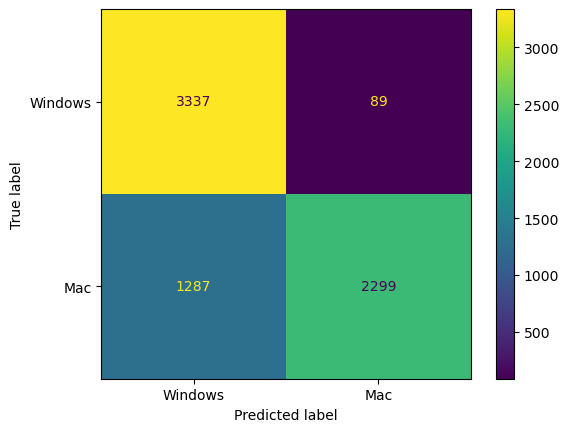

In [135]:
#plot confusion matrix graph
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,preds2), display_labels = ['Windows', 'Mac'])
disp.plot()

In [136]:
# tp: Mac
# tn: Windows
# fn: predicted Windows and actually Mac
# fp: predicted Mac and actualy Windows
tn2, fp2, fn2, tp2 = confusion_matrix(y_test,preds2).ravel()

# Calculate the specificity (negative class)
print(tn2/ (tn2+fp2))
# Sensitivity (positive class)
print(tp2/(tp2+fn2))
# F1 Score -> harmonic mean of precision and recall.
print(f1_score(y_test, preds2))

0.9740221833041448
0.6411042944785276
0.7696685637763642


In [137]:
print("True Negatives: %s" % tn2)
print("False Positives: %s" % fp2)
print("False Negatives: %s" % fn2)
print("True Positives: %s" % tp2)

True Negatives: 3337
False Positives: 89
False Negatives: 1287
True Positives: 2299


In [138]:
#Call report
print(classification_report(y_test,preds2))   #Macro Avg between 2 values, Weighted is poportional avg.

              precision    recall  f1-score   support

           0       0.72      0.97      0.83      3426
           1       0.96      0.64      0.77      3586

    accuracy                           0.80      7012
   macro avg       0.84      0.81      0.80      7012
weighted avg       0.84      0.80      0.80      7012



# Model3: Naive Bayes using GridSearch

In [152]:
#Identify pipeline cvec + nb
pipe3 = Pipeline([
    ('cvec', CountVectorizer(stop_words=no_stopword)),
    ('nb', MultinomialNB())])

In [165]:
#select best parameter for cvec from previous model and selection of hyperparameter value for Multinomial
param_values3={
    'cvec__max_features':[5000],
    'cvec__min_df':[2],
    'cvec__max_df':[0.9],
    'cvec__ngram_range' : [(1,2)],
    'nb__class_prior':[(0.5,0.5)],
    'nb__alpha': (1, 0.1, 0.01, 0.001, 0.0001)
}

In [166]:
#instantiate model
grid3 = GridSearchCV(pipe3,
                    param_grid=param_values3,
                    cv=5,
                    verbose=1) # 2 To make sure that it shows as many details and 1 is showing less

In [167]:
#train model with train data
grid3.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['windows',
                                                                    'mac', 'os',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', ...])),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'nb__alpha': (1, 0.1, 0.01, 0.001, 0.0001),
                         'nb__class_prior': [(0.5, 0.5)]},
             verbose=1)

In [170]:
#best params from grid search
grid3.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.0001,
 'nb__class_prior': (0.5, 0.5)}

In [171]:
#best score from model
grid3.best_score_

0.935300316122234

In [172]:
#accuracy on train data
grid3.score(X_train,y_train)

0.945626975763962

In [173]:
#accuracy on test data
grid3.score(X_test,y_test)

0.933970336565887

In [174]:
#predict on unseen data
preds3 = grid3.predict(X_test)
preds3

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [175]:
#plot confusion matrix
confusion_matrix(y_test,preds3)

array([[3279,  147],
       [ 316, 3270]], dtype=int64)

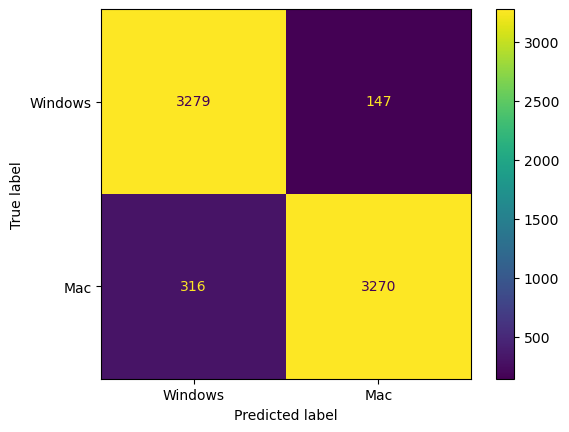

In [176]:
#put confusion matrix on graph
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,preds3), display_labels = ['Windows', 'Mac'])
disp.plot()

In [182]:
# tp: Mac
# tn: Windows
# fn: predicted Windows and actually Mac
# fp: predicted Mac and actualy Windows
tn3, fp3, fn3, tp3 = confusion_matrix(y_test,preds3).ravel()

# Calculate the specificity (negative class)
print(f'Specificity : {tn3/ (tn3+fp3)}')
# Sensitivity (positive class)
print(f'Sensitivity : {tp3/(tp3+fn3)}')
# F1 Score -> harmonic mean of precision and recall.
print(f'F1 Score : {f1_score(y_test, preds3)}')

Specificity : 0.9740221833041448
Sensitivity : 0.6411042944785276
F1 Score : 0.9338854776524346


In [178]:
print("True Negatives: %s" % tn3)
print("False Positives: %s" % fp3)
print("False Negatives: %s" % fn3)
print("True Positives: %s" % tp3)

True Negatives: 3337
False Positives: 89
False Negatives: 1287
True Positives: 2299


In [179]:
#call report
print(classification_report(y_test,preds3))   #Macro Avg between 2 values, Weighted is poportional avg.

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3426
           1       0.96      0.91      0.93      3586

    accuracy                           0.93      7012
   macro avg       0.93      0.93      0.93      7012
weighted avg       0.94      0.93      0.93      7012



# Model4: RandomForest using GridSearch

In [190]:
#identify pipeline or RF model and cvec
pipe4 = Pipeline([
    ('cvec', CountVectorizer(stop_words=no_stopword)),
    ('rf', RandomForestClassifier())])

In [191]:
#use best param of cvec from previous model and range of values in rf function
param_values4={
    'cvec__max_features':[5000],
    'cvec__min_df':[2],
    'cvec__max_df':[0.9],
    'cvec__ngram_range' : [(1,2)],
    'rf__n_estimators': [50,100,150,200],
    'rf__max_depth':[None,2,4,6]}

In [192]:
#instatiate grid search
grid4 = GridSearchCV(pipe4,
                    param_grid=param_values4,
                    cv=5,
                    verbose=1) # 2 To make sure that it shows as many details and 1 is showing less

In [193]:
#train grid on train data
grid4.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['windows',
                                                                    'mac', 'os',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', ...])),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'rf__max_depth': [None, 2, 4, 6],
                         'rf__n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [209]:
#best params from this model
grid4.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'rf__max_depth': None,
 'rf__n_estimators': 200}

In [211]:
#best score from this model
grid4.best_score_

0.9331225851773797

In [212]:
#accuracy on train data
grid4.score(X_train,y_train)

0.9999297506146821

In [213]:
#accuracy on test data
grid4.score(X_test,y_test)

0.9301197946377638

In [194]:
#predict on unseen data
preds4 = grid4.predict(X_test)
preds4

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [195]:
#plot confusion matrix
confusion_matrix(y_test,preds4)

array([[3257,  169],
       [ 321, 3265]], dtype=int64)

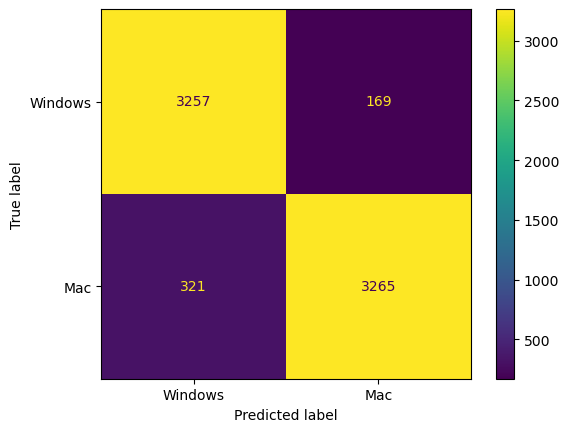

In [196]:
#plot confusion matrix graph
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,preds4), display_labels = ['Windows', 'Mac'])
disp.plot()

In [197]:
# tp: Mac
# tn: Windows
# fn: predicted Windows and actually Mac
# fp: predicted Mac and actualy Windows
tn4, fp4, fn4, tp4 = confusion_matrix(y_test,preds4).ravel()

# Calculate the specificity (negative class)
print(f'Specificity : {tn4/ (tn4+fp4)}')
# Sensitivity (positive class)
print(f'Sensitivity : {tp4/(tp4+fn4)}')
# F1 Score -> harmonic mean of precision and recall.
print(f'F1 Score : {f1_score(y_test, preds4)}')

Specificity : 0.9506713368359603
Sensitivity : 0.9104852203011712
F1 Score : 0.9301994301994301


In [198]:
print("True Negatives: %s" % tn4)
print("False Positives: %s" % fp4)
print("False Negatives: %s" % fn4)
print("True Positives: %s" % tp4)

True Negatives: 3257
False Positives: 169
False Negatives: 321
True Positives: 3265


In [199]:
#call report
print(classification_report(y_test,preds4))   #Macro Avg between 2 values, Weighted is poportional avg.

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3426
           1       0.95      0.91      0.93      3586

    accuracy                           0.93      7012
   macro avg       0.93      0.93      0.93      7012
weighted avg       0.93      0.93      0.93      7012



# Model 5 : KNN (K-nearest neighbor) using GridSearch

In [205]:
#identify pipeline for knn model
pipe5 = Pipeline([
    ('cvec', CountVectorizer(stop_words=no_stopword)),
    ('knn', KNeighborsClassifier())])

In [206]:
#using best values for vec from previous model and select range of neighbors for knn model
param_values5={
    'cvec__max_features':[5000],
    'cvec__min_df':[2],
    'cvec__max_df':[0.9],
    'cvec__ngram_range' : [(1,2)],
    'knn__n_neighbors': [3,5,7,9]}

In [207]:
#instantiate model
grid5 = GridSearchCV(pipe5,
                    param_grid=param_values5,
                    cv=5,
                    verbose=1) # 2 To make sure that it shows as many details and 1 is showing less

In [208]:
#training model with train data
grid5.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=['windows',
                                                                    'mac', 'os',
                                                                    'i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', ...])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'knn__n_neighbors': [3, 5, 7, 9]},
             verbose=1)

In [217]:
#get best param after training
grid5.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'knn__n_neighbors': 9}

In [214]:
#best model score
grid5.best_score_

0.756656129258869

In [215]:
#accuracy score on train data
grid5.score(X_train,y_train)

0.847418335089568

In [216]:
#accuracy score on test data
grid5.score(X_test,y_test)

0.764403879064461

In [218]:
#predict on unseen data (validation data)
preds5 = grid5.predict(X_test)
preds5

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [219]:
#plot confusion matrix
confusion_matrix(y_test,preds5)

array([[2910,  516],
       [1136, 2450]], dtype=int64)

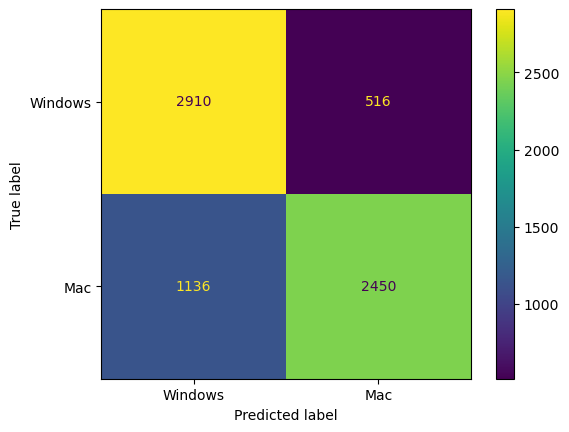

In [220]:
#plot confusion matrix graph
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,preds5), display_labels = ['Windows', 'Mac'])
disp.plot()

In [221]:
# tp: Mac
# tn: Windows
# fn: predicted Windows and actually Mac
# fp: predicted Mac and actualy Windows
tn5, fp5, fn5, tp5 = confusion_matrix(y_test,preds4).ravel()

# Calculate the specificity (negative class)
print(f'Specificity : {tn5/ (tn5+fp5)}')
# Sensitivity (positive class)
print(f'Sensitivity : {tp5/(tp5+fn5)}')
# F1 Score -> harmonic mean of precision and recall.
print(f'F1 Score : {f1_score(y_test, preds5)}')

Specificity : 0.9506713368359603
Sensitivity : 0.9104852203011712
F1 Score : 0.7478632478632479


In [222]:
print("True Negatives: %s" % tn5)
print("False Positives: %s" % fp5)
print("False Negatives: %s" % fn5)
print("True Positives: %s" % tp5)

True Negatives: 3257
False Positives: 169
False Negatives: 321
True Positives: 3265


In [223]:
#call report
print(classification_report(y_test,preds5))   #Macro Avg between 2 values, Weighted is poportional avg.

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      3426
           1       0.83      0.68      0.75      3586

    accuracy                           0.76      7012
   macro avg       0.77      0.77      0.76      7012
weighted avg       0.77      0.76      0.76      7012

